In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.optim.lr_scheduler

In [4]:
# Data loading and preprocessing
csv_file = "Documents/csv/xray_dataset_covid19/xrays.csv"
df = pd.read_csv(csv_file)

y = df['label']
X = df.drop(columns=['label'])

device = torch.device("cuda")

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
# Convolutional Block Class
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool_size, activation):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size // 2))
        self.activation = nn.SELU()
        self.pool = nn.MaxPool2d(pool_size)

    def forward(self, x):
        out = self.conv(x)
        out = self.activation(out)
        out = self.pool(out)
        return out

# Deep CNN Model
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.block1 = ConvBlock(3, 256, kernel_size=4, pool_size=3, activation="selu")
        self.block2 = ConvBlock(256, 512, kernel_size=3, pool_size=2, activation="selu")
        self.block3 = ConvBlock(512, 1024, kernel_size=2, pool_size=2, activation="selu")
        self.fc = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.mean(x, dim=[2, 3])
        x = self.fc(x)
        return x

In [7]:
model = DeepCNN()
model.to(device)

DeepCNN(
  (block1): ConvBlock(
    (conv): Conv2d(3, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (activation): SELU()
    (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): SELU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): ConvBlock(
    (conv): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (activation): SELU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

In [8]:
# Optimizer, Loss, and Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

# Training parameters
num_epochs = 32
best_val_loss = float('inf')
early_stopping_patience = 5
early_stopping_counter = 0

In [9]:
from sklearn.metrics import roc_auc_score

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    train_predictions_list = []
    train_labels_list = []
    train_probabilities_list = []  # To store predicted probabilities for AUC-ROC

    for inputs, labels in train_loader:
        labels_one_hot = torch.zeros(labels.size(0), 2).to(device)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

        inputs, labels = inputs.to(device), labels_one_hot
        inputs = inputs.view(-1, 3, 224, 224)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Convert the model's output to binary predictions
        binary_predictions = torch.sigmoid(outputs).detach().cpu().numpy()
        train_probabilities_list.extend(binary_predictions[:, 1].tolist())  # Store probabilities for class 1
        binary_predictions = np.argmax(binary_predictions, axis=1)
        train_predictions_list.extend(binary_predictions.tolist())

        binary_labels = np.argmax(labels.cpu().numpy(), axis=1)
        train_labels_list.extend(binary_labels.tolist())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = accuracy_score(train_labels_list, train_predictions_list)
    train_auc_roc = roc_auc_score(train_labels_list, train_probabilities_list)  # Calculate train AUC-ROC

    model.eval()
    val_loss = 0.0
    val_predictions_list = []
    val_true_labels_list = []
    val_probabilities_list = []  # To store predicted probabilities for AUC-ROC

    with torch.no_grad():
        for inputs, labels in val_loader:
            labels_one_hot = torch.zeros(labels.size(0), 2).to(device)
            labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

            inputs, labels = inputs.to(device), labels_one_hot
            inputs = inputs.view(-1, 3, 224, 224)

            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            binary_predictions = torch.sigmoid(outputs).cpu().numpy()
            val_probabilities_list.extend(binary_predictions[:, 1].tolist())  # Store probabilities for class 1
            binary_predictions = np.argmax(binary_predictions, axis=1)
            val_predictions_list.extend(binary_predictions.tolist())

            binary_labels = np.argmax(labels.cpu().numpy(), axis=1)
            val_true_labels_list.extend(binary_labels.tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_true_labels_list, val_predictions_list)
    val_auc_roc = roc_auc_score(val_true_labels_list, val_probabilities_list)  # Calculate validation AUC-ROC

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"Train AUC-ROC: {train_auc_roc:.4f}, Val AUC-ROC: {val_auc_roc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping.")
        break


Epoch 1/32, Train Loss: 24.0300, Val Loss: 0.5912, Train Accuracy: 0.6896, Val Accuracy: 0.8608, Train AUC-ROC: 0.6904, Val AUC-ROC: 0.9519
Epoch 2/32, Train Loss: 0.4703, Val Loss: 0.3149, Train Accuracy: 0.8768, Val Accuracy: 0.9114, Train AUC-ROC: 0.9327, Val AUC-ROC: 0.9603
Epoch 3/32, Train Loss: 0.2370, Val Loss: 0.2716, Train Accuracy: 0.9194, Val Accuracy: 0.8987, Train AUC-ROC: 0.9732, Val AUC-ROC: 0.9654
Epoch 4/32, Train Loss: 0.2459, Val Loss: 0.2205, Train Accuracy: 0.9242, Val Accuracy: 0.9241, Train AUC-ROC: 0.9709, Val AUC-ROC: 0.9686
Epoch 5/32, Train Loss: 0.2461, Val Loss: 0.2193, Train Accuracy: 0.9289, Val Accuracy: 0.9241, Train AUC-ROC: 0.9797, Val AUC-ROC: 0.9724
Epoch 6/32, Train Loss: 0.1538, Val Loss: 0.2070, Train Accuracy: 0.9431, Val Accuracy: 0.9367, Train AUC-ROC: 0.9872, Val AUC-ROC: 0.9769
Epoch 7/32, Train Loss: 0.1506, Val Loss: 0.1650, Train Accuracy: 0.9597, Val Accuracy: 0.9494, Train AUC-ROC: 0.9916, Val AUC-ROC: 0.9776
Epoch 8/32, Train Loss: 0.

In [16]:
# Specify the file path and file name with a valid extension (e.g., '.pt')
file_path = "Documents/csv/xray.pt"

# Save the model's state_dict to the specified file
torch.save(model.state_dict(), file_path)

In [17]:
torch.save(model, file_path)

In [19]:
import requests

# Specify the URL where the model file is hosted
model_url = "http://localhost:8892/lab/tree/jaishreeram.ipynb"

# Specify the local file path where you want to save the downloaded model
local_file_path = "Documents/csv/xxx.pt"

# Download the model file
response = requests.get(model_url)
with open(local_file_path, "wb") as file:
    file.write(response.content)


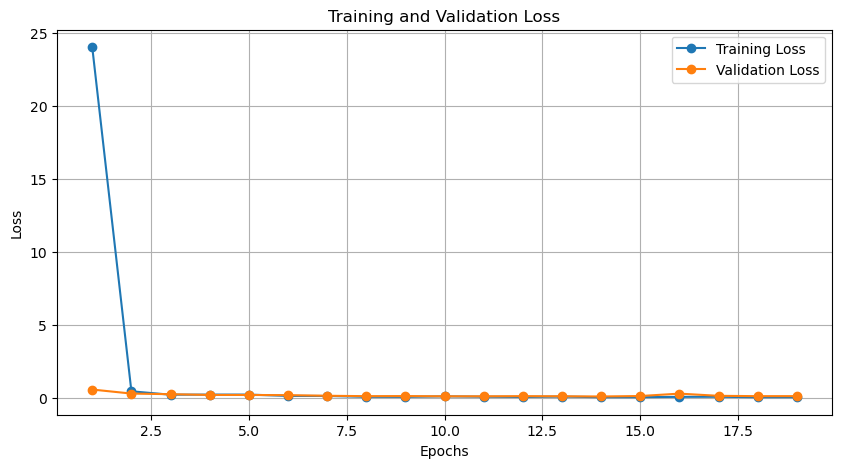

In [23]:
import matplotlib.pyplot as plt

# Provided epoch-wise data
epochs = list(range(1, 20))  # Assuming you have data for 19 epochs
train_losses = [24.0300, 0.4703, 0.2370, 0.2459, 0.2461, 0.1538, 0.1506, 0.0918, 0.0884, 0.1244, 0.1001, 0.0820, 0.1081, 0.0659, 0.0664, 0.0906, 0.0961, 0.0651, 0.0691,]
val_losses = [0.5912, 0.3149, 0.2716, 0.2205, 0.2193, 0.2070, 0.1650, 0.1372, 0.1443, 0.1279, 0.1285, 0.1386, 0.1295, 0.1157, 0.1469, 0.3112, 0.1612, 0.1384, 0.1398]

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image

# Define the base directory
base_dir = "C:\\Users\\MITUL\\Documents\\csv\\xray_dataset_covid19\\try\\"

# Define the subdirectories
subdirs = ["Normal", "Pneumonia"]

# Initialize lists to store data and labels
data = []
labels = []

# Define the target resolution
target_resolution = (224, 224)  # Adjust this resolution according to your images

# Define a Torch transform to resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize(target_resolution),
    transforms.ToTensor()
])

# Loop through each subdirectory
for label, subdir in enumerate(subdirs):
    # Define the subdirectory path
    subdir_path = os.path.join(base_dir, subdir)

    # Loop through each image in the class
    for file_name in os.listdir(subdir_path):
        # Construct the full path of the image
        file_path = os.path.join(subdir_path, file_name)

        # Open the image using PIL and apply the transform
        image = Image.open(file_path)

        # Remove the alpha channel if present
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        image = transform(image)

        # Flatten the Torch tensor to a 1D array
        flattened_array = image.view(-1).numpy()

        # Append the flattened array and label to the lists
        data.append(flattened_array)
        labels.append(label)

# Create a DataFrame from the lists
num_channels = 3  # Three color channels (RGB)
num_pixels = target_resolution[0] * target_resolution[1]
columns = [f'pixel_{i}' for i in range(num_channels * num_pixels)]
df = pd.DataFrame(data, columns=columns)
df['label'] = labels

# Save the DataFrame to a CSV file
csv_file_path = "C:\\Users\\MITUL\\Documents\\csv\\xray_dataset_covid19\\xray_dataset.csv"
df.to_csv(csv_file_path, index=False)

# Display the DataFrame
print(df.head())


    pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6  \
0  0.121569  0.152941  0.207843  0.282353  0.407843  0.549020  0.709804   
1  0.066667  0.066667  0.066667  0.066667  0.066667  0.066667  0.066667   
2  0.039216  0.039216  0.035294  0.035294  0.035294  0.035294  0.035294   
3  0.313726  0.294118  0.223529  0.231373  0.317647  0.333333  0.466667   
4  0.027451  0.003922  0.003922  0.003922  0.003922  0.003922  0.003922   

    pixel_7   pixel_8   pixel_9  ...  pixel_150519  pixel_150520  \
0  0.815686  0.835294  0.811765  ...      0.000000      0.000000   
1  0.066667  0.066667  0.066667  ...      0.027451      0.027451   
2  0.031373  0.035294  0.035294  ...           NaN           NaN   
3  0.443137  0.356863  0.235294  ...      0.105882      0.109804   
4  0.003922  0.003922  0.003922  ...      0.003922      0.003922   

   pixel_150521  pixel_150522  pixel_150523  pixel_150524  pixel_150525  \
0      0.000000      0.000000      0.000000      0.000000      0.

In [51]:
csv_file = "Documents/csv/xray_dataset_covid19/xrays.csv"
og = pd.read_csv(csv_file)

In [52]:
og 

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,label
0,30,30,30,32,32,32,32,32,32,32,...,33,33,33,34,34,34,31,31,31,0
1,24,24,24,36,36,36,31,31,31,28,...,33,33,33,34,34,34,27,27,27,0
2,35,35,35,38,38,38,36,36,36,37,...,35,35,35,35,35,35,33,33,33,0
3,66,66,66,74,74,74,74,74,74,75,...,140,140,140,128,128,128,117,117,117,0
4,38,38,38,40,40,40,40,40,40,40,...,44,44,44,45,45,45,42,42,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,55,55,55,43,43,43,35,35,35,32,...,47,47,47,51,51,51,56,56,56,1
524,25,25,25,24,24,24,30,30,30,32,...,17,17,17,10,10,10,9,9,9,1
525,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
526,118,118,118,178,178,178,8,8,8,0,...,15,15,15,22,22,22,27,27,27,1


In [53]:
df 

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,label
0,0.121569,0.152941,0.207843,0.282353,0.407843,0.549020,0.709804,0.815686,0.835294,0.811765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.027451,0.027451,0.027451,0.031373,0.031373,0.031373,0.031373,0.031373,0.035294,0
2,0.039216,0.039216,0.035294,0.035294,0.035294,0.035294,0.035294,0.031373,0.035294,0.035294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0.313726,0.294118,0.223529,0.231373,0.317647,0.333333,0.466667,0.443137,0.356863,0.235294,...,0.105882,0.109804,0.109804,0.113725,0.109804,0.109804,0.109804,0.101961,0.098039,1
4,0.027451,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.019608,0.086275,1
5,0.835294,0.827451,0.823529,0.819608,0.811765,0.811765,0.807843,0.803922,0.800000,0.803922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [55]:
import torch

# Assuming df contains your data with columns 'X' and 'y'
X = df.drop(columns=['label'])  # Replace 'y' with the actual column name for your labels
y = df['label']  # Replace 'y' with the actual column name for your labels

# Convert X and y to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)


In [59]:
# Assuming num_channels, height, and width based on your model's architecture
num_channels = 3
height = 224
width = 224

# Reshape your flattened input data to match the expected shape
X_test_tensor = X_test_tensor.view(-1, num_channels, height, width)


In [60]:


def evaluate_model(model, X_tensor, y_tensor, device):
    model.eval()  # Set the model to evaluation mode
    X_tensor = X_tensor.to(device)
    y_tensor = y_tensor.to(device)

    with torch.no_grad():  # Disable gradient computation for evaluation
        outputs = model(X_tensor)
            
        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy
        correct_predictions = (predicted == y_tensor).sum().item()
        total_samples = y_tensor.size(0)
        accuracy = correct_predictions / total_samples

    return accuracy


In [61]:
accuracy = evaluate_model(model, X_test_tensor, y_test_tensor, device)
print(f"Accuracy on test set: {accuracy:.2%}")


Accuracy on test set: 92.59%
